In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfolio.timeseries import perf_stats
import talib

In [2]:
PERIODS = 200
SLOW_MA = 200
FAST_MA = 100
BREAKOUT = 75

In [38]:
results = pd.read_pickle('results/maximize_return_2007-2012.pickle')
returns = results.returns

In [39]:
equity_curve = (returns + 1).cumprod()
days = len(returns)

In [40]:
equity_curve.tail()

2012-12-24 18:00:00+00:00    3.178761
2012-12-26 21:00:00+00:00    3.202854
2012-12-27 21:00:00+00:00    3.247691
2012-12-28 21:00:00+00:00    3.226490
2012-12-31 21:00:00+00:00    3.282038
Name: returns, dtype: float64

In [41]:
indicators = pd.DataFrame(equity_curve.copy())
indicators.rename(columns={'returns': 'equity'}, inplace=True)
indicators['return'] = indicators['equity'].pct_change()
indicators['std'] = indicators['return'].rolling(PERIODS).std()
indicators['mean_return'] = indicators['return'].rolling(PERIODS).mean()
indicators['mean_monthly_return'] = (indicators['mean_return'] +1)**21 -1
indicators['return_21_days'] = indicators['equity'].pct_change(21)
indicators['zscore'] = (indicators['return_21_days'] - indicators['return_21_days'].rolling(PERIODS).mean()) \
                        / indicators['return_21_days'].rolling(PERIODS).std() 
indicators['monthly_std'] = indicators['std'] * np.sqrt(21)
indicators['slow_ma'] = talib.EMA(indicators.equity.values, timeperiod=SLOW_MA)
indicators['fast_ma'] = talib.EMA(indicators.equity.values, timeperiod=FAST_MA)
indicators.tail()

,equity,return,std,mean_return,mean_monthly_return,return_21_days,zscore,monthly_std,slow_ma,fast_ma
2012-12-24 18:00:00+00:00,3.178761,0.009366,0.010031,0.000025,0.000527,0.019079,0.619705,0.045969,3.273493,3.244071
2012-12-26 21:00:00+00:00,3.202854,0.007579,0.010044,0.000051,0.001065,0.017848,0.574362,0.046027,3.272790,3.243254
2012-12-27 21:00:00+00:00,3.247691,0.013999,0.010092,0.000127,0.002661,0.027317,0.862800,0.046247,3.272541,3.243342
2012-12-28 21:00:00+00:00,3.226490,-0.006528,0.010076,0.000042,0.000883,0.007802,0.250049,0.046176,3.272082,3.243009
2012-12-31 21:00:00+00:00,3.282038,0.017216,0.010144,0.000104,0.002189,0.023586,0.738772,0.046485,3.272181,3.243781


In [42]:
in_the_market = True
high_water = 0
results = pd.Series()
for day in range(1, days):
    equity = equity_curve[:day]
    ind = indicators.iloc[:day]
    high_water = max(high_water, equity[-1])
    cutoff = high_water - ((abs(indicators['mean_monthly_return'][day]) + 1.25 * indicators['monthly_std'][day]) * equity[-1])
    if in_the_market:
        # we're in the market, results = strategy results
        results[equity_curve.index[day]] = indicators['return'][day]
        if equity[-1] < cutoff and indicators['zscore'][day] > 2.5:
            in_the_market = False
            cutoff_date = equity_curve.index[day]
            cutoff_price = equity[-1]
    else:
        results[equity_curve.index[day]] = 0
        if equity_curve.index[day-BREAKOUT] >= cutoff_date:
            #if equity[-1] >= equity.rolling(BREAKOUT).max()[-1]:
            #if equity[-1] >= cutoff:
            #if equity[-1] >= cutoff_price:
            #if equity[-1] >= equity[-252]:
            #if indicators['fast_ma'][day] > indicators['slow_ma'][day]:
            if equity[-1] >= equity.rolling(BREAKOUT).max()[-1] and indicators['fast_ma'][day] > indicators['slow_ma'][day]:
                in_the_market = True
                high_water = 0

In [43]:
results.head()

2007-01-04 21:00:00+00:00   -0.002145
2007-01-05 21:00:00+00:00   -0.011553
2007-01-08 21:00:00+00:00    0.005316
2007-01-09 21:00:00+00:00    0.008945
2007-01-10 21:00:00+00:00   -0.002563
dtype: float64

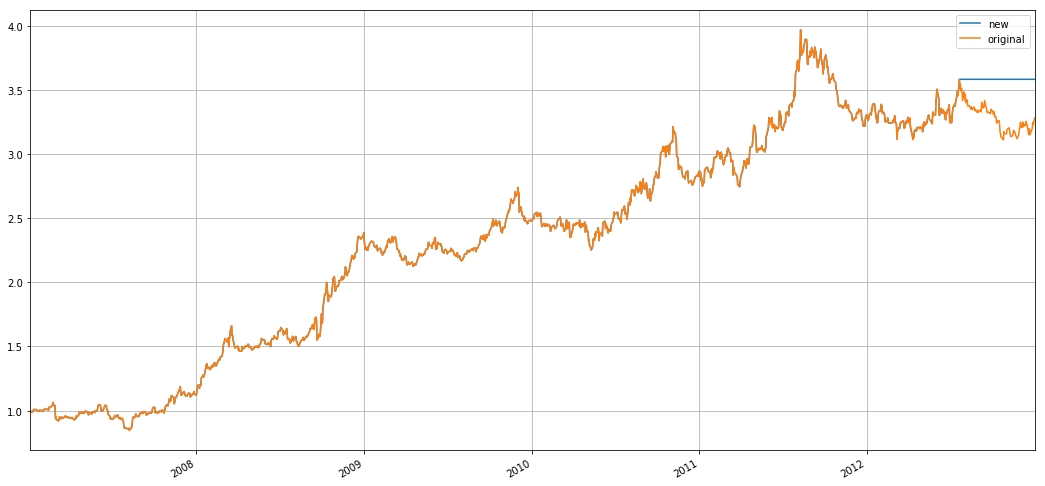

In [44]:
new_returns = pd.DataFrame({'original': indicators['return'], 
                           'new': results,
                           })
new_equity_path = (new_returns + 1).cumprod()
new_equity_path.plot(figsize=(18,9), grid=True, xlim=(new_equity_path.index[0], new_equity_path.index[-1]));

No optimization

In [45]:
perf_stats(returns)

Annual return          0.219377
Cumulative returns     2.282038
Annual volatility      0.208470
Sharpe ratio           1.056089
Calmar ratio           1.014580
Stability              0.872539
Max drawdown          -0.216224
Omega ratio            1.210520
Sortino ratio          1.533667
Skew                  -0.158909
Kurtosis               7.375355
Tail ratio             1.036062
Daily value at risk   -0.025391
dtype: float64

With optimization

In [46]:
perf_stats(results)

Annual return          0.237516
Cumulative returns     2.582646
Annual volatility      0.205311
Sharpe ratio           1.141142
Calmar ratio           1.102395
Stability              0.890914
Max drawdown          -0.215455
Omega ratio            1.239317
Sortino ratio          1.660638
Skew                  -0.171480
Kurtosis               8.000678
Tail ratio             1.036646
Daily value at risk   -0.024937
dtype: float64